# SARIMA

Média móvel auto regressiva integrada sazonal, SARIMA ou ARIMA sazonal, é uma extensão do modelo ARIMA. Esse modelo adiciona 3 hiperparâmetros para especificar a autorregressão (AR), diferenciação (I) e a média móvel para a componete sazonal da série temporal, assim como um parâmetro adicional para o período da sazonalidade.

Configurar esse modelo requer selecionar os hiperparâmetros para os elementos de tendencia e sazonais da série temporal.

## Componentes

```
SARIMA(p,d,q)(P,D,Q)m
```

### Tendência

- **p**: ordem de autorregressão
- **d**: ordem de diferenciação
- **q**: ordem de média móvel

### Sazonalidade

- **P**: ordem de autorregressão
- **Q**: ordem de diferenciação
- **D**: ordem de média móvel
- **m**: número de instantes de tempo para um período sazonal

Os hiperparâmetros de tendência e sazonalidade podem ser configurados através da análise dos gráficos de autocorrelação e autocorrelação parcial. Outra abordagem é usar a metodologia de *grid search*.

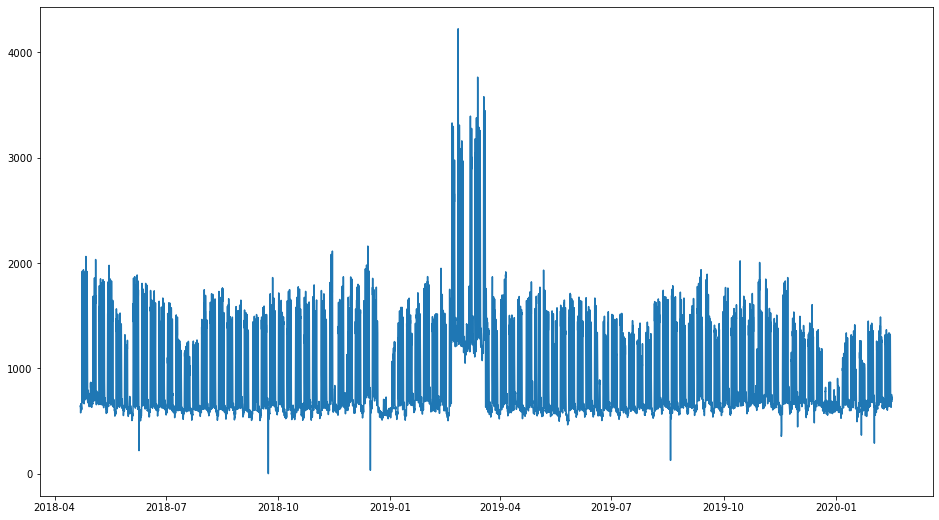

In [7]:
from math import sqrt
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


df0 = pd.read_csv("MeMas_5min.csv",header=0,infer_datetime_format=True,parse_dates=['Data'],index_col=['Data'])
df = df0.resample('H').sum()

plt.figure(figsize=(16,9))
plt.plot(df)

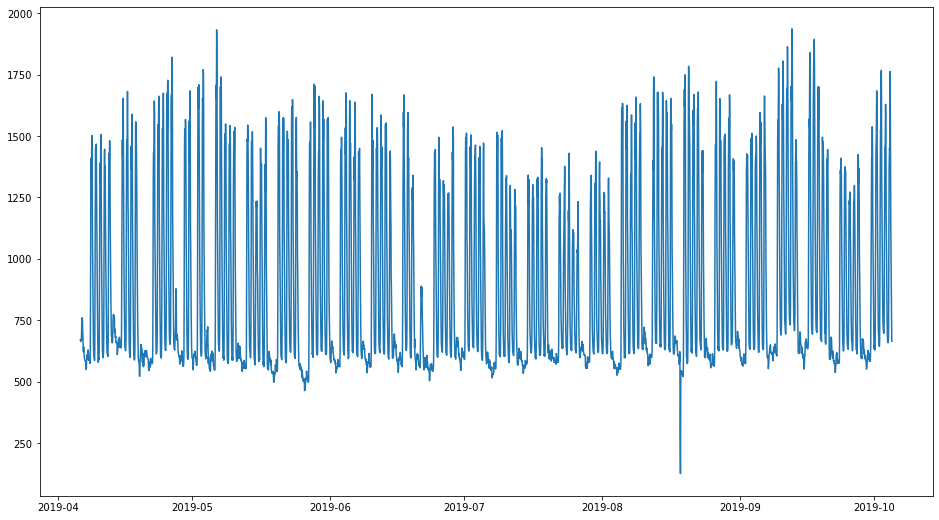

In [8]:
plt.figure(figsize=(16,9))
plt.plot(df.truncate('2019-04-06','2019-10-05'))

## Function *sarima_forecast*

Recebe os valores dos hiperparâmetros e faz uma previsão com 168 horas (1 semana).

In [ ]:
def sarima_forecast(history, config):
	order, sorder, trend = config
	# define model
	model = SARIMAX(history, order=order, seasonal_order=sorder, trend=trend, enforce_stationarity=False, enforce_invertibility=False)
	# fit model
	model_fit = model.fit(disp=False)
	yhat = model_fit.predict(len(history), len(history)+168)
	return yhat

## Divisão dos datasets de treino e teste

Como os resultados utilizando datasets com sazonalidades bem definidas são melhores, eu irei dividir os dados manualmente pegando os dados de sábado a sábado.

In [ ]:
def train_test_split(data, n_test):
	return data[:-n_test], data[-n_test:]

## RMSE

Função que calcula a métrica RMSE expressa pela seguinte equação: 

$$RMSE = \sqrt{\sum_{n=1}^{N}\frac{(saída_{esperada}-saída_{calculada})^2}{n}}$$

In [ ]:
def measure_rmse(actual, predicted):
	return sqrt(mean_squared_error(actual, predicted))

## Function *walk_foward_validation*



In [ ]:
def walk_forward_validation(data, n_test, cfg, train, test):
	predictions = list()
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# fit model and make forecast for history
		yhat = sarima_forecast(history, cfg)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
	# estimate prediction error
	error = measure_rmse(test, predictions)
	return error

In [ ]:
# score a model, return None on failure
def score_model(data, n_test, cfg, debug=False):
	result = None
	# convert config to a key
	key = str(cfg)
	# show all warnings and fail on exception if debugging
	if debug:
		result = walk_forward_validation(data, n_test, cfg)
	else:
		# one failure during model validation suggests an unstable config
		try:
			# never show warnings when grid searching, too noisy
			with catch_warnings():
				filterwarnings("ignore")
				result = walk_forward_validation(data, n_test, cfg)
		except:
			error = None
	# check for an interesting result
	if result is not None:
		print(' > Model[%s] %.3f' % (key, result))
	return (key, result)